# Best ML Model for Sentiment Analysis (Rinconada Dataset)

This notebook follows the research process to train and select the best ML algorithm (SVM, Naive Bayes, Random Forest) for sentiment classification.

In [32]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

## Load and Preprocess Data

In [33]:
# Load dataset
df = pd.read_csv('DATASET_FINAL_NO_STOPWORDS.csv')
# Load stopwords
with open('RBL Nabua Stop Words.csv', encoding='utf-8') as f:
    stopwords = set([line.strip() for line in f if line.strip()])
# Preprocess function
def preprocess(text):
    tokens = text.lower().split()
    tokens = [t for t in tokens if t not in stopwords]
    return ' '.join(tokens)
df['processed'] = df['Sentiment'].astype(str).apply(preprocess)
df[['Sentiment', 'processed', 'Label']].head()

,Sentiment,processed,Label
0,magmaan,magmaan,positive
1,mahiwason,mahiwason,positive
2,simpleng baha nanaman lriga,simpleng baha nanaman lriga,negative
3,uda karapatan reklamo kadaklan bayad 3 taon ha...,uda karapatan reklamo kadaklan bayad 3 taon ha...,negative
4,maray diri apektado,maray diri apektado,negative


## Feature Extraction (TF-IDF)

In [34]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed'])
y = df['Label']

Label distribution:
Label
neutral     11330
positive     6157
negative     4097
Name: count, dtype: int64


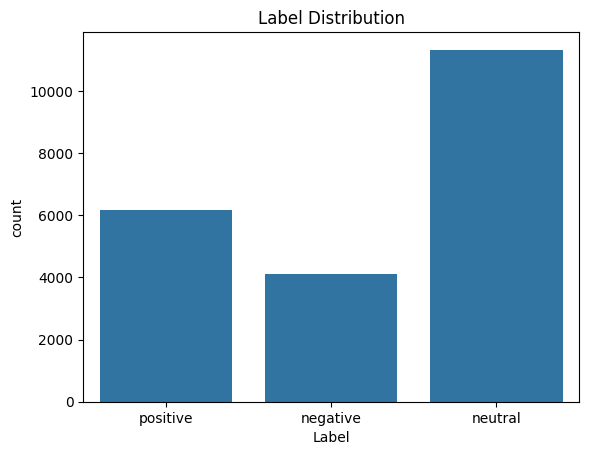

Imbalance ratio (max/min): 2.765438125457652
Train accuracy: 0.840
Test accuracy: 0.620
Train accuracy: 0.840
Test accuracy: 0.620


In [ ]:
# # Check dataset balance and potential issues before training
# import matplotlib.pyplot as plt
# import seaborn as sns
# from collections import Counter
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report
# print('Label distribution:')
# print(df['Label'].value_counts())
# sns.countplot(x='Label', data=df)
# plt.title('Label Distribution')
# plt.show()

# # Check for class imbalance ratio
# label_counts = df['Label'].value_counts()
# imbalance_ratio = label_counts.max() / label_counts.min() if label_counts.min() > 0 else None
# print(f'Imbalance ratio (max/min): {imbalance_ratio}')

# # Quick overfitting check: train simple model and compare train/test scores
# X_simple = vectorizer.fit_transform(df['processed'])
# y_simple = df['Label']
# X_train_simple, X_test_simple, y_train_simple, y_test_simple = train_test_split(X_simple, y_simple, test_size=0.2, stratify=y_simple, random_state=1)
# clf = LogisticRegression(max_iter=200)
# clf.fit(X_train_simple, y_train_simple)
# train_score = clf.score(X_train_simple, y_train_simple)
# test_score = clf.score(X_test_simple, y_test_simple)
# print(f'Train accuracy: {train_score:.3f}')
# print(f'Test accuracy: {test_score:.3f}')
# if train_score - test_score > 0.1:
#     print('Warning: Possible overfitting detected (train > test by >0.1)')
# else:
#     print('No strong overfitting detected.')

## Train/Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## K-Fold Cross Validation & Model Training

In [37]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [38]:
models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42)
    ,'NaiveBayes': MultinomialNB()
    ,'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42)
}

In [39]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels for regression metrics
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

# Calibrate classifiers and evaluate metrics
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'MCC': [], 'MSE': [], 'RMSE': [], 'R2': []}
for name, model in models.items():
    # Use probability calibration for SVM and RandomForest (NaiveBayes is already probabilistic)
    if name in ['SVM', 'RandomForest']:
        calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
        calibrated.fit(X_train, y_train)
        y_pred = calibrated.predict(X_test)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
    metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
    metrics['F1 Score'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
    metrics['MCC'].append(matthews_corrcoef(y_test, y_pred))
    # Encode predictions for regression metrics
    y_pred_encoded = le.transform(y_pred)
    mse = np.mean((y_test_encoded - y_pred_encoded) ** 2)
    metrics['MSE'].append(mse)
    metrics['RMSE'].append(np.sqrt(mse))
    # R2 score for encoded labels
    ss_res = np.sum((y_test_encoded - y_pred_encoded) ** 2)
    ss_tot = np.sum((y_test_encoded - np.mean(y_test_encoded)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0
    metrics['R2'].append(r2)
    print(f"{name} - Accuracy: {metrics['Accuracy'][-1]:.3f}, Precision: {metrics['Precision'][-1]:.3f}, Recall: {metrics['Recall'][-1]:.3f}, F1: {metrics['F1 Score'][-1]:.3f}, MCC: {metrics['MCC'][-1]:.3f}, MSE: {metrics['MSE'][-1]:.3f}, RMSE: {metrics['RMSE'][-1]:.3f}, R2: {metrics['R2'][-1]:.3f}")

metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)
metrics_df

SVM - Accuracy: 0.623, Precision: 0.623, Recall: 0.623, F1: 0.595, MCC: 0.338, MSE: 0.468, RMSE: 0.684, R2: -0.005
NaiveBayes - Accuracy: 0.608, Precision: 0.640, Recall: 0.608, F1: 0.554, MCC: 0.303, MSE: 0.450, RMSE: 0.671, R2: 0.035
RandomForest - Accuracy: 0.617, Precision: 0.614, Recall: 0.617, F1: 0.593, MCC: 0.330, MSE: 0.477, RMSE: 0.691, R2: -0.024
RandomForest - Accuracy: 0.617, Precision: 0.614, Recall: 0.617, F1: 0.593, MCC: 0.330, MSE: 0.477, RMSE: 0.691, R2: -0.024


,Accuracy,Precision,Recall,F1 Score,MCC,MSE,RMSE,R2
Model,,,,,,,,
SVM,0.622655,0.623153,0.622655,0.595081,0.338427,0.468381,0.684384,-0.005225
NaiveBayes,0.607830,0.639880,0.607830,0.553635,0.303221,0.449849,0.670708,0.034546
RandomForest,0.617327,0.614485,0.617327,0.592809,0.329932,0.477183,0.690785,-0.024117


## Select Best Model & Evaluate on Test Set

In [40]:
best_model_name = max(results, key=lambda k: results[k].mean())
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f'Best Model: {best_model_name}')
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Model: SVM
Test Accuracy: 0.6279823951818393
Classification Report:
               precision    recall  f1-score   support

    negative       0.61      0.39      0.48       819
     neutral       0.64      0.84      0.72      2266
    positive       0.61      0.40      0.48      1232

    accuracy                           0.63      4317
   macro avg       0.62      0.54      0.56      4317
weighted avg       0.62      0.63      0.61      4317



## Save Best Model and Vectorizer

In [41]:
# Create and fit a new TfidfVectorizer for each model, saved with model name
for name in models.keys():
    vectorizer = TfidfVectorizer()
    vectorizer.fit(df['processed'])
    joblib.dump(vectorizer, f'{name}_tfidf_vectorizer.obj')
    print(f'Saved TF-IDF vectorizer for {name} as {name}_tfidf_vectorizer.obj')

# Save all models
for name, model in models.items():
    model_path = f'{name}_model.obj'
    joblib.dump(model, model_path)
    print(f'Saved {name} model as {model_path}')

Saved TF-IDF vectorizer for SVM as SVM_tfidf_vectorizer.obj
Saved TF-IDF vectorizer for NaiveBayes as NaiveBayes_tfidf_vectorizer.obj
Saved TF-IDF vectorizer for RandomForest as RandomForest_tfidf_vectorizer.obj
Saved SVM model as SVM_model.obj
Saved NaiveBayes model as NaiveBayes_model.obj
Saved RandomForest model as RandomForest_model.obj
Saved TF-IDF vectorizer for RandomForest as RandomForest_tfidf_vectorizer.obj
Saved SVM model as SVM_model.obj
Saved NaiveBayes model as NaiveBayes_model.obj
Saved RandomForest model as RandomForest_model.obj


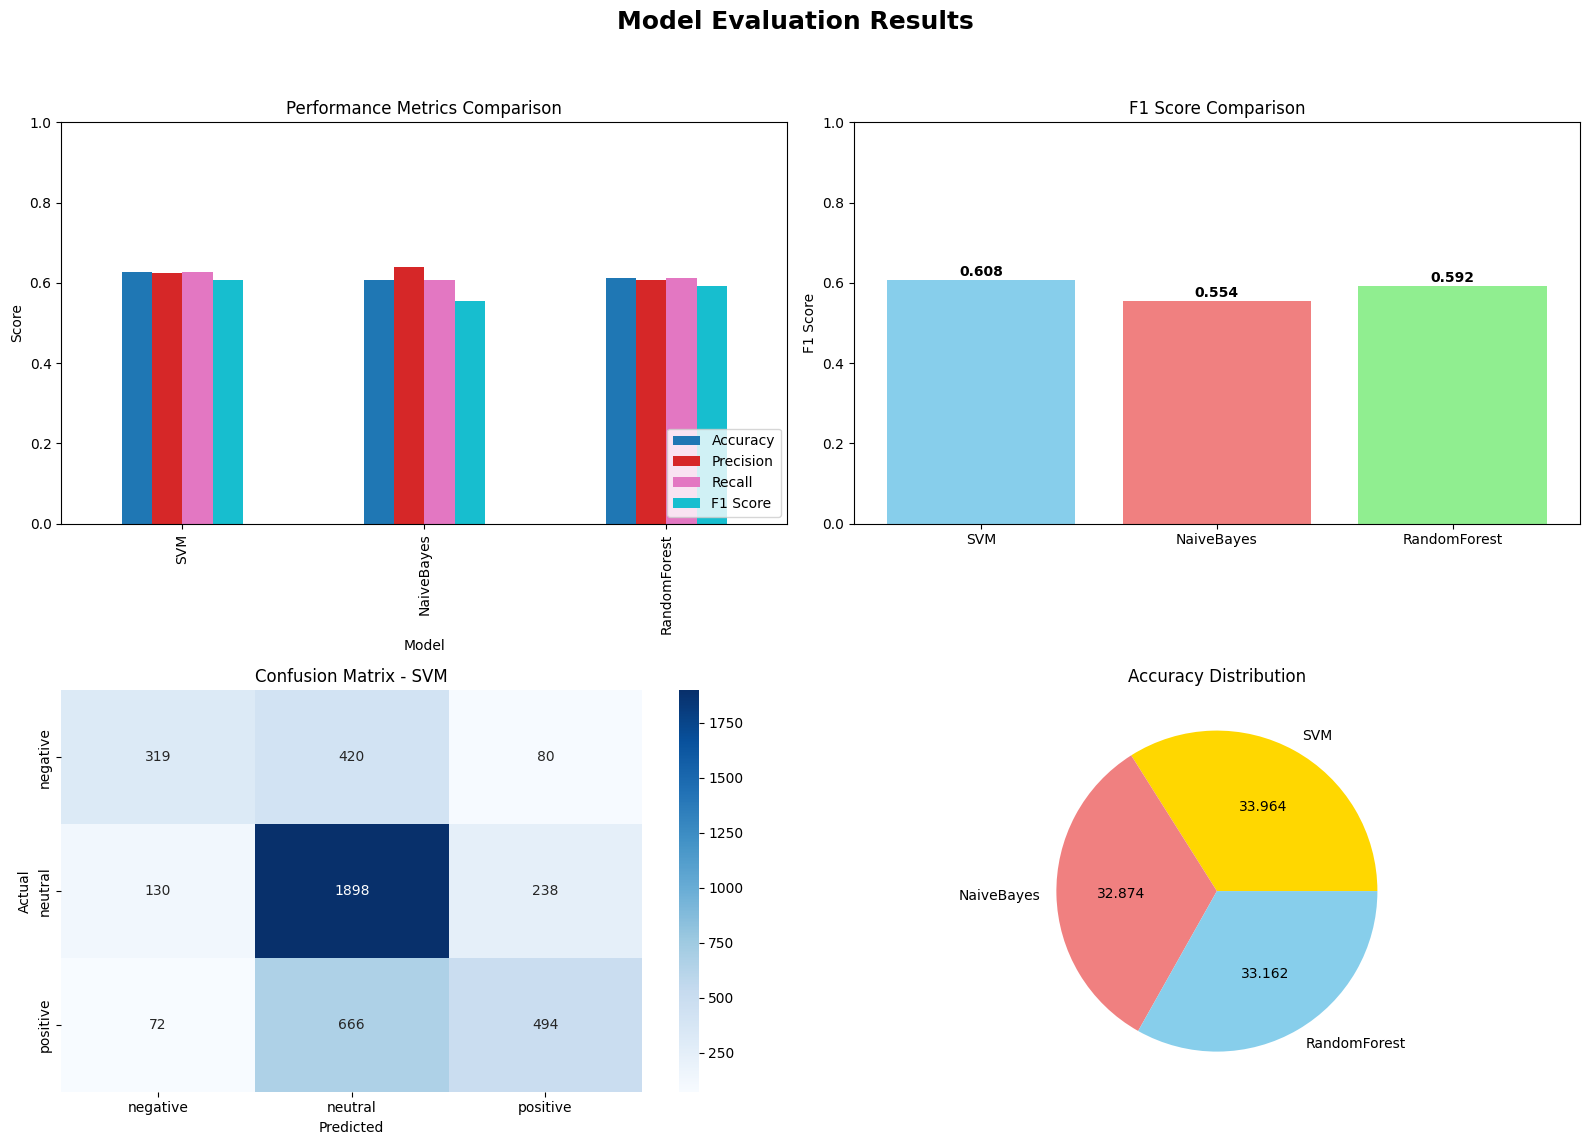

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Compute metrics for the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Compute metrics for all models
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_all = model.predict(X_test)
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred_all))
    metrics['Precision'].append(precision_score(y_test, y_pred_all, average='weighted', zero_division=0))
    metrics['Recall'].append(recall_score(y_test, y_pred_all, average='weighted', zero_division=0))
    metrics['F1 Score'].append(f1_score(y_test, y_pred_all, average='weighted', zero_division=0))
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('Model', inplace=True)

# Confusion Matrix for best model
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)

# Classification report as DataFrame
cr = classification_report(y_test, y_pred, output_dict=True)
cr_dict = {k: [v['precision'], v['recall'], v['f1-score']] for k, v in cr.items() if k in best_model.classes_}
cr_df = pd.DataFrame(cr_dict, index=['Precision', 'Recall', 'F1-Score']).T

# Plot all in one figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Evaluation Results', fontsize=18, fontweight='bold')

# 1. Metrics Bar Plot
metrics_df.plot(kind='bar', ax=axes[0,0], colormap='tab10')
axes[0,0].set_title('Performance Metrics Comparison')
axes[0,0].set_ylabel('Score')
axes[0,0].set_ylim(0,1)
axes[0,0].legend(loc='lower right')

# 2. F1 Score Comparison
axes[0,1].bar(metrics_df.index, metrics_df['F1 Score'], color=['skyblue','lightcoral','lightgreen'])
for i, v in enumerate(metrics_df['F1 Score']):
    axes[0,1].text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
axes[0,1].set_title('F1 Score Comparison')
axes[0,1].set_ylabel('F1 Score')
axes[0,1].set_ylim(0,1)

# 3. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_, ax=axes[1,0])
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')

# 4. Accuracy Pie Chart
axes[1,1].pie(metrics_df['Accuracy'], labels=metrics_df.index, autopct='%1.3f', colors=['gold','lightcoral','skyblue'])
axes[1,1].set_title('Accuracy Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute metrics for the best model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

# # Compute metrics for all models
# metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}
# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred_all = model.predict(X_test)
#     metrics['Model'].append(name)
#     metrics['Accuracy'].append(accuracy_score(y_test, y_pred_all))
#     metrics['Precision'].append(precision_score(y_test, y_pred_all, average='weighted', zero_division=0))
#     metrics['Recall'].append(recall_score(y_test, y_pred_all, average='weighted', zero_division=0))
#     metrics['F1 Score'].append(f1_score(y_test, y_pred_all, average='weighted', zero_division=0))

# metrics_df = pd.DataFrame(metrics)
# metrics_df.set_index('Model', inplace=True)

# # Grouped bar plot for all metrics
# metrics_df.plot(kind='bar', figsize=(10,6))
# plt.title('Performance Metrics Comparison')
# plt.ylabel('Score')
# plt.ylim(0,1)
# plt.legend(loc='lower right')
# plt.show()

Accuracy: 0.628
Precision: 0.624
Recall: 0.628
F1 Score: 0.608
